# Class Weight



## 0.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### (2) 데이터 로딩

> 예제 데이터는 공정간 불량을 예측하는 데이터입니다.  
여기서는 class imbalance 에 대한 샘플링과 성능에만 초점을 맞추겠습니다.


In [2]:
path = "secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)

target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

## 1.데이터 탐색

## 2.데이터 준비


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4, random_state = 2021)

In [5]:
x_train.shape

(940, 52)

## 3.모델링

In [6]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV, StratifiedKFold

### (1) 기본 모델링

* 로지스틱 회귀 + 데이터 그대로 이용

In [7]:
model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[587   1]
 [ 39   0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       588
           1       0.00      0.00      0.00        39

    accuracy                           0.94       627
   macro avg       0.47      0.50      0.48       627
weighted avg       0.88      0.94      0.91       627



### (2) Class Weight 조정

#### 1) class_weight = 'balanced'

In [8]:
# class_weight = 'balanced'

model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[370 218]
 [ 16  23]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.63      0.76       588
           1       0.10      0.59      0.16        39

    accuracy                           0.63       627
   macro avg       0.53      0.61      0.46       627
weighted avg       0.90      0.63      0.72       627



 * 반복실행 후 f1 score 확인하기

In [9]:
result = []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    model = LogisticRegression(class_weight='balanced')
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    result.append(f1_score(y_val, pred, pos_label=1))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


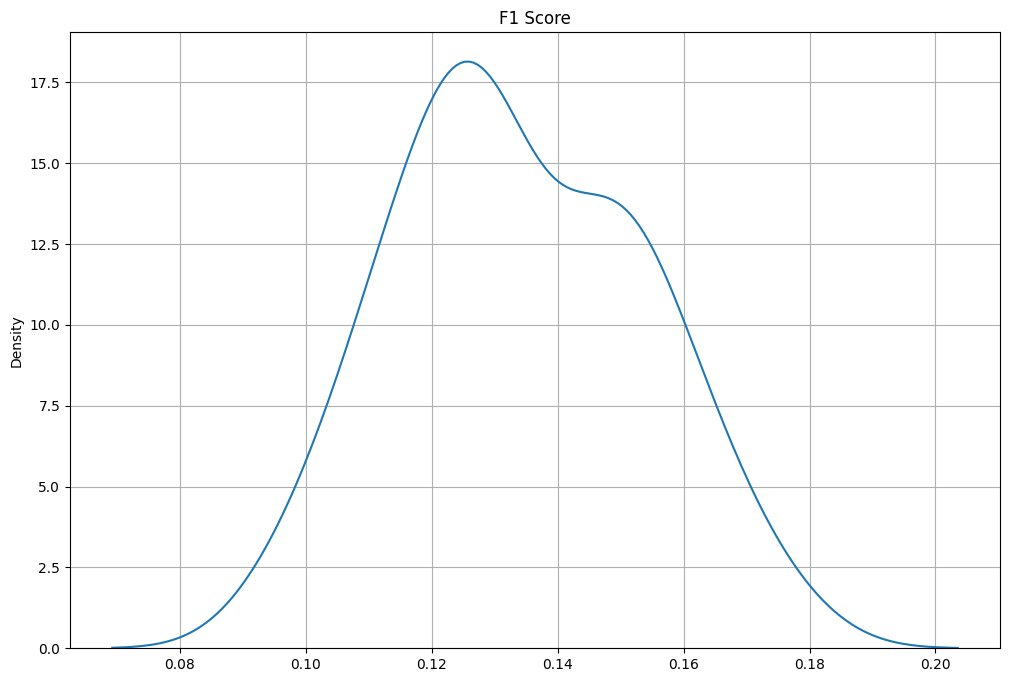

In [10]:
plt.figure(figsize=(12, 8))
sns.distplot(result, hist = False)
plt.title('F1 Score')
plt.grid()
plt.show()

#### 2) class_weight = 수동
* y_train 비율의 역수로

In [11]:
# 다수, 소수 클래스 비율 저장
c0 = (y_train.value_counts() / y_train.shape[0])[0]
c1 = (y_train.value_counts() / y_train.shape[0])[1]
c0, c1

(0.9340425531914893, 0.06595744680851064)

In [12]:
# class_weight = 수도

model = LogisticRegression(class_weight={0:c1, 1:c0})
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[383 202]
 [ 23  19]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       585
           1       0.09      0.45      0.14        42

    accuracy                           0.64       627
   macro avg       0.51      0.55      0.46       627
weighted avg       0.89      0.64      0.73       627



#### 3) class_weight = GridSearch로 조절

In [13]:
# class_weight = 비율로 수동 조절하도록 파라미터 설정
weights = np.linspace(0.01,.99,100)

params = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
params

{'class_weight': [{0: 0.01, 1: 0.99},
  {0: 0.0198989898989899, 1: 0.9801010101010101},
  {0: 0.029797979797979796, 1: 0.9702020202020202},
  {0: 0.039696969696969696, 1: 0.9603030303030303},
  {0: 0.049595959595959596, 1: 0.9504040404040404},
  {0: 0.059494949494949496, 1: 0.9405050505050505},
  {0: 0.06939393939393938, 1: 0.9306060606060607},
  {0: 0.07929292929292929, 1: 0.9207070707070707},
  {0: 0.08919191919191918, 1: 0.9108080808080808},
  {0: 0.09909090909090908, 1: 0.9009090909090909},
  {0: 0.10898989898989898, 1: 0.891010101010101},
  {0: 0.11888888888888888, 1: 0.8811111111111112},
  {0: 0.12878787878787878, 1: 0.8712121212121212},
  {0: 0.1386868686868687, 1: 0.8613131313131313},
  {0: 0.1485858585858586, 1: 0.8514141414141414},
  {0: 0.15848484848484848, 1: 0.8415151515151515},
  {0: 0.16838383838383839, 1: 0.8316161616161616},
  {0: 0.1782828282828283, 1: 0.8217171717171717},
  {0: 0.18818181818181817, 1: 0.8118181818181818},
  {0: 0.19808080808080808, 1: 0.8019191919191

In [14]:
# Grid Search : 그리드서치로 튜닝
# StratifiedKFold : 층화추출
model = GridSearchCV(LogisticRegression(), params
                    , cv= StratifiedKFold(5), scoring='f1')
model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 0.01, 1: 0.99},
                                          {0: 0.0198989898989899,
                                           1: 0.9801010101010101},
                                          {0: 0.029797979797979796,
                                           1: 0.9702020202020202},
                                          {0: 0.039696969696969696,
                                           1: 0.9603030303030303},
                                          {0: 0.049595959595959596,
                                           1: 0.9504040404040404},
                                          {0: 0.059494949494...
                                           1: 0.7722222222222223},
                                          {0: 0.23767676767676768,
                                           1: 0.7623232323232323},
                                          {0: 0.24757575757575756,
                                           1: 0.7524242424242424},
                                          {0: 0.25747474747474747,
                                           1: 0.7425252525252526},
                                          {0: 0.2673737373737374,
                                           1: 0.7326262626262626},
                                          {0: 0.2772727272727273,
                                           1: 0.7227272727272727},
                                          {0: 0.2871717171717172,
                                           1: 0.7128282828282828},
                                          {0: 0.29707070707070704,
                                           1: 0.702929292929293}, ...]},
             scoring='f1')

In [15]:
model.cv_results_

{'mean_fit_time': array([0.04136105, 0.03561726, 0.04663148, 0.04505157, 0.03546534,
        0.03936319, 0.03820662, 0.04329095, 0.03741593, 0.0393816 ,
        0.03487163, 0.03801446, 0.04249029, 0.03659582, 0.03790326,
        0.04168901, 0.04245729, 0.03774829, 0.03901196, 0.03837795,
        0.04773159, 0.10781965, 0.09212313, 0.09074798, 0.10198445,
        0.1030642 , 0.09448104, 0.03678946, 0.03697042, 0.03684406,
        0.04068432, 0.03494725, 0.03492408, 0.03313894, 0.04102683,
        0.0422256 , 0.03736696, 0.04016767, 0.03564296, 0.03813744,
        0.0365263 , 0.03477368, 0.03484735, 0.03401656, 0.03793817,
        0.03752131, 0.03690181, 0.03613954, 0.03998923, 0.04097357,
        0.037394  , 0.03584237, 0.03600941, 0.03471365, 0.04683185,
        0.03705711, 0.03619461, 0.03481011, 0.04326787, 0.03382812,
        0.03447461, 0.03339562, 0.03627901, 0.04722829, 0.04378867,
        0.03878665, 0.04435215, 0.04607625, 0.03634906, 0.03827062,
        0.04922776, 0.12729783,

In [16]:
model.best_params_

{'class_weight': {0: 0.059494949494949496, 1: 0.9405050505050505}}

{'class_weight': {0: 0.059494949494949496, 1: 0.9405050505050505}}


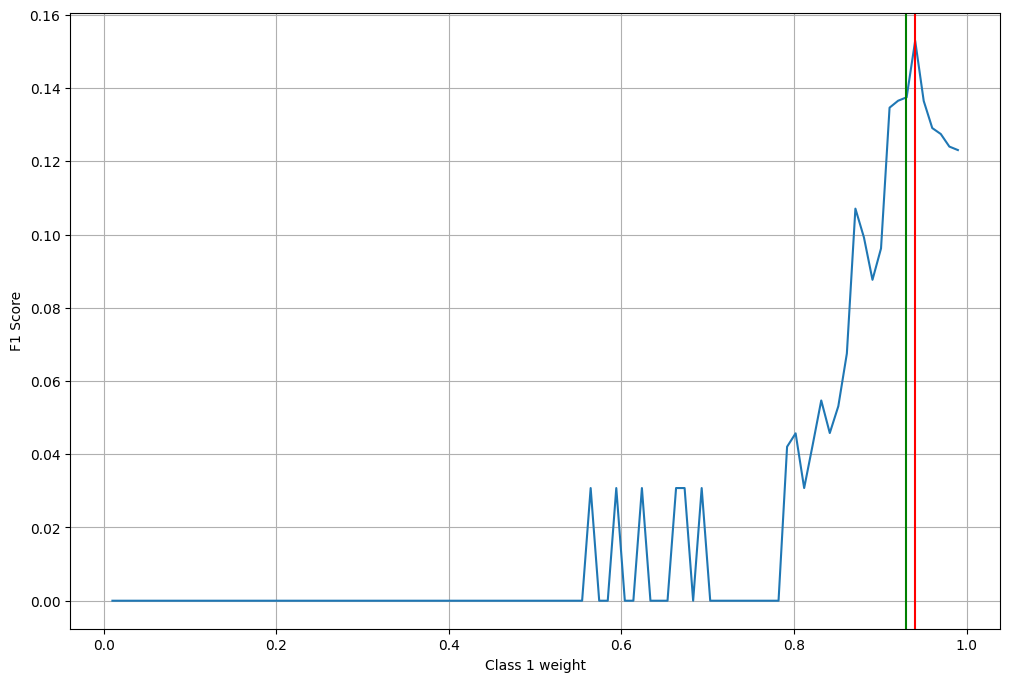

In [19]:
weight_1 = 1.0 - weights
f1 = model.cv_results_['mean_test_score']

print(model.best_params_)
plt.figure(figsize=(12, 8))
plt.plot(weight_1, f1)
plt.axvline(model.best_params_['class_weight'][1], color = 'r')
plt.axvline(0.93, color = 'g')
plt.ylabel('F1 Score')
plt.xlabel('Class 1 weight')
plt.grid()
plt.show()

## 4.실습 : 고객이탈 예측 - class weight 조정하기

### (1) 데이터 준비

* 데이터 로딩

In [20]:
path = "mobile_class_imbalance.csv"
data = pd.read_csv(path)

target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [21]:
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,145297,71,37,969515,478,4,1,avg,very_little,no,0
1,0,115956,0,11,899704,710,0,5,unsat,very_high,actively_looking_into_it,0
2,0,40683,212,15,844664,188,24,5,very_unsat,very_little,no,0
3,1,33043,0,81,539732,162,1,1,unsat,very_little,never_thought,0
4,1,50743,0,22,430005,318,16,5,unsat,very_high,actively_looking_into_it,0


In [ ]:
y.value_counts() / y.shape[0]

0    0.971286
1    0.028714
Name: CHURN, dtype: float64

* 가변수화

In [22]:
cat = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']

for v in cat :
    dumm = pd.get_dummies(x[v], prefix=v, drop_first=True)
    x = pd.concat([x, dumm], axis=1)
    x.drop(v, axis=1, inplace = True)

* 데이터 분할

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 2000, random_state=2021)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state=2021)

### (2)기본모델링
> * 데이터셋을 그대로 모델링을 수행하시오.
* 알고리즘 : 로지스틱회귀, decision tree, SVM 등
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [24]:
model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[1949    0]
 [  51    0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1949
           1       0.00      0.00      0.00        51

    accuracy                           0.97      2000
   macro avg       0.49      0.50      0.49      2000
weighted avg       0.95      0.97      0.96      2000



### (3) class weight : 값의 비율을 역으로 지정 'balanced'
> * class_weight 값을 지정해서 모델링 해 봅시다.
* 알고리즘 : 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.
* resampling 후 수행한 모델과 성능에 대해 비교해 봅시다.

In [25]:
# class_weight = 'balanced'

model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[1246  703]
 [  22   29]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.77      1949
           1       0.04      0.57      0.07        51

    accuracy                           0.64      2000
   macro avg       0.51      0.60      0.42      2000
weighted avg       0.96      0.64      0.76      2000



### (4) class weight : Grid Search 튜닝
> * class_weight 값을 조금씩 조정하며 튜닝해 봅시다.
* 최적의 성능 지점과 (3)의 비율과 비교해 봅시다.

In [26]:
# class_weight = 비율로 수동 조절하도록 파라미터 설정
weights = np.linspace(0.01,.99,100)

params = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}
params

{'class_weight': [{0: 0.01, 1: 0.99},
  {0: 0.0198989898989899, 1: 0.9801010101010101},
  {0: 0.029797979797979796, 1: 0.9702020202020202},
  {0: 0.039696969696969696, 1: 0.9603030303030303},
  {0: 0.049595959595959596, 1: 0.9504040404040404},
  {0: 0.059494949494949496, 1: 0.9405050505050505},
  {0: 0.06939393939393938, 1: 0.9306060606060607},
  {0: 0.07929292929292929, 1: 0.9207070707070707},
  {0: 0.08919191919191918, 1: 0.9108080808080808},
  {0: 0.09909090909090908, 1: 0.9009090909090909},
  {0: 0.10898989898989898, 1: 0.891010101010101},
  {0: 0.11888888888888888, 1: 0.8811111111111112},
  {0: 0.12878787878787878, 1: 0.8712121212121212},
  {0: 0.1386868686868687, 1: 0.8613131313131313},
  {0: 0.1485858585858586, 1: 0.8514141414141414},
  {0: 0.15848484848484848, 1: 0.8415151515151515},
  {0: 0.16838383838383839, 1: 0.8316161616161616},
  {0: 0.1782828282828283, 1: 0.8217171717171717},
  {0: 0.18818181818181817, 1: 0.8118181818181818},
  {0: 0.19808080808080808, 1: 0.8019191919191

In [27]:
# Grid Search : 그리드서치로 튜닝
# StratifiedKFold : 층화추출
model = GridSearchCV(LogisticRegression(), params
                    , cv= StratifiedKFold(5), scoring='f1')
model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 0.01, 1: 0.99},
                                          {0: 0.0198989898989899,
                                           1: 0.9801010101010101},
                                          {0: 0.029797979797979796,
                                           1: 0.9702020202020202},
                                          {0: 0.039696969696969696,
                                           1: 0.9603030303030303},
                                          {0: 0.049595959595959596,
                                           1: 0.9504040404040404},
                                          {0: 0.059494949494...
                                           1: 0.7722222222222223},
                                          {0: 0.23767676767676768,
                                           1: 0.7623232323232323},
                                          {0: 0.24757575757575756,
                                           1: 0.7524242424242424},
                                          {0: 0.25747474747474747,
                                           1: 0.7425252525252526},
                                          {0: 0.2673737373737374,
                                           1: 0.7326262626262626},
                                          {0: 0.2772727272727273,
                                           1: 0.7227272727272727},
                                          {0: 0.2871717171717172,
                                           1: 0.7128282828282828},
                                          {0: 0.29707070707070704,
                                           1: 0.702929292929293}, ...]},
             scoring='f1')

In [28]:
model.cv_results_

{'mean_fit_time': array([0.08920898, 0.04867182, 0.04600916, 0.06074324, 0.04991555,
        0.04345155, 0.04119124, 0.05327945, 0.0597785 , 0.04259262,
        0.05018177, 0.03901181, 0.04898081, 0.0511745 , 0.05273066,
        0.0563798 , 0.0469388 , 0.04902306, 0.04386115, 0.04989448,
        0.04257188, 0.05337954, 0.05356274, 0.05181475, 0.05139608,
        0.05232944, 0.04846101, 0.05252314, 0.05436654, 0.04893098,
        0.05223646, 0.05692906, 0.05436187, 0.05508342, 0.09933372,
        0.14960203, 0.11369939, 0.13650379, 0.17614498, 0.05818005,
        0.05795317, 0.06231251, 0.06281462, 0.06593933, 0.07315755,
        0.06678777, 0.06220231, 0.06819267, 0.06440196, 0.05683641,
        0.05818586, 0.0598856 , 0.05945029, 0.06370802, 0.06465368,
        0.05031939, 0.0703043 , 0.06368303, 0.06214719, 0.06248164,
        0.05359578, 0.04633198, 0.07890124, 0.06371608, 0.05747485,
        0.07197161, 0.06275406, 0.10738583, 0.16823344, 0.12973361,
        0.13938432, 0.1531322 ,

In [29]:
c0 = (y_train.value_counts() / y_train.shape[0])[0]
c1 = (y_train.value_counts() / y_train.shape[0])[1]
c0, c1

(0.9708436724565757, 0.02915632754342432)

In [30]:
model.best_params_

{'class_weight': {0: 0.059494949494949496, 1: 0.9405050505050505}}

{'class_weight': {0: 0.059494949494949496, 1: 0.9405050505050505}}


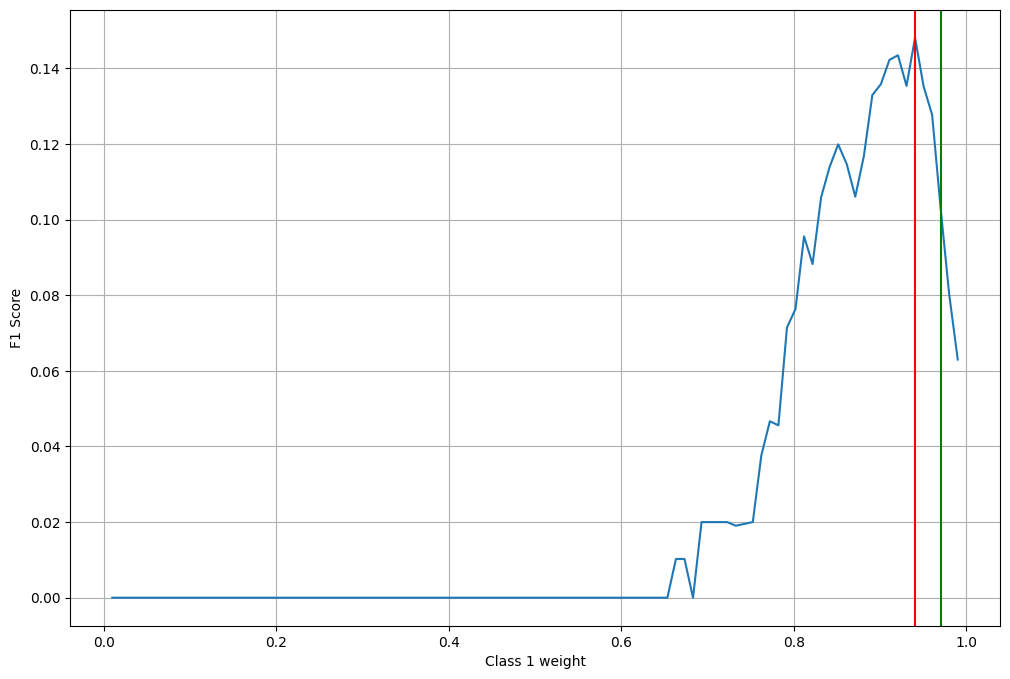

In [31]:
weight_1 = 1.0 - weights
f1 = model.cv_results_['mean_test_score']

print(model.best_params_)
plt.figure(figsize=(12, 8))
plt.plot(weight_1, f1)
plt.axvline(model.best_params_['class_weight'][1], color = 'r')
plt.axvline(0.97, color = 'g')
plt.ylabel('F1 Score')
plt.xlabel('Class 1 weight')
plt.grid()
plt.show()